`Name:` **ISHIKA SHARMA**

`E-mail ID:` **ishikasharma.aug2001@gmail.com**

`College:` **IIT DHARWAD**

### __ARTIFICIAL INTELLIGENCE__ _MAJOR PROJECT_

_`TOPIC:`_

# Deep Convolutional Generative Adversarial Network **(DCGAN)**

**1. Importing the required Libraries:**

In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

'2.4.1'

In [ ]:
# To generate GIFs
!pip install -q imageio
!pip install -q git+https://github.com/tensorflow/docs

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

**2. Loading the dataset:**

#### __MNIST Dataset:__
It is a dataset containing `hand-written digits` from 0 to 9. 

Our generator will generate handwritten digits resembling the MNIST data.

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [ ]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [ ]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

**3. Creating the Model:**
### __GENERATOR__ 
It is a generative network, which generates the images, from the input of a `vector of noise`. We will use the following layers in our model:

  + **_`Dense:`_** The noise layer of our generator.
  + **_`Conv2DTranspose:`_** Upscaling and convolving the image at the same time.
  + **_`LeakyReLU:`_** We use it to avoid gradient vanish.
  + **_`BatchNormalization:`_** Normalizing the result of a convolution to get better results.
  + **_`Reshape:`_** Transforming a one-dimensional vector into a three-dimensional array.

**`Basic Idea`**: From the random noise, we will convolve the data until we generate an image.

The generator goes the other way: It is the artist who is trying to fool the discriminator. This network consists of 3 convolutional layers. Each convolutional layer performs a convolution and then performs batch normalization and a leaky ReLu as well. Then, we return the tanh activation function.

In [ ]:

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

**Checking our generator works fine:**

Our network is not trained yet so, it should generate only noise.

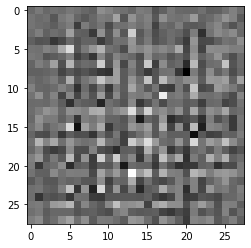

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### __DISCRIMINATOR__
Our discriminator network is a normal convolutional neural network. It will take an image as input and as output will return a binary value.

 For every layer of the network, we are going to perform a convolution, then we use LeakyRelu to avoid gradient vanish, followed by a dropout layers to avoid overfitting. We complete the structure of dicriminator with  Flatten and Dense layers.

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Our model, yet untrained so, the discriminator should classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-2.54669e-05]], shape=(1, 1), dtype=float32)


**4. Define the loss and optimizers:**

We need to define three loss functions:
+ The loss of the generator,
+ The loss of the discriminator when using real images, and
+ The loss of the discriminator when using fake images. 

The sum of the fake image and real image loss is the overall discriminator loss.

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### __Discriminator LOSS__
_This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s_

First, we define our loss for the real images. For that, we pass the output of the discriminator when dealing with real images and compare it with the labels, which are all 1, which means true.

Then, we define the loss for our fake images. This time we pass in the output of the discriminator when dealing with fake images and compare it to our labels, which are all 0, which means they are fake.

Lastly, Our total discriminator loss is sum of the above two losses.

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### __Generator LOSS__
_The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s._

For the generator loss, we do the same like we did for fake loss, but instead of comparing the output with all 0s, we compare it with 1s, since we want to fool the discriminator.

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

We optimize the generator and discriminator individually, since we wnat to train both the networks seperately.

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

**5. Saving the Checkpoints**

We need to save checkpoints to reload our model back, if we accidenly get diconnected.

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


**6. Training the GAN model:**

Training is the hardest part and since a GAN contains two separately trained networks, its training algorithm must address two complications:

+ GANs must juggle two different kinds of training (generator and discriminator).
+ GAN convergence is hard to identify.

As the generator improves with training, the discriminator performance gets worse because the discriminator can’t easily tell the difference between real and fake. If the generator succeeds perfectly, then the discriminator has a 50% accuracy. In effect, the discriminator flips a coin to make its prediction.

This progression poses a problem for convergence of the GAN as a whole: the discriminator feedback gets less meaningful over time. If the GAN continues training past the point when the discriminator is giving completely random feedback, then the generator starts to train on junk feedback, and its quality may collapse.

In [ ]:
EPOCHS = 70
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving randon noise as input, which is then used to produce an image. The discriminator then classifies real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

**7. Generate and Save Images:**

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

We call the train() method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

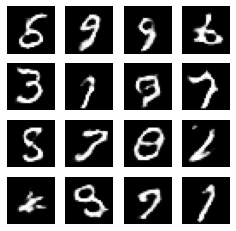

In [ ]:
train(train_dataset, EPOCHS)

**Restore the latest checkpoint**

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

**8. Create GIF:**

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

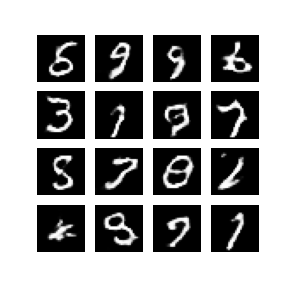

In [ ]:
display_image(EPOCHS)

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


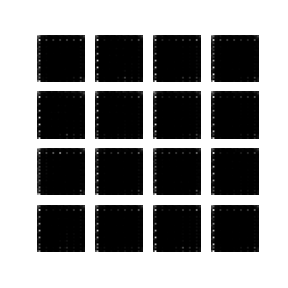

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)